# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels from the given data path.
    
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, height, width, 3) representing RGB images.
    labels (np.ndarray): A numpy array of shape (N) with corresponding labels.
    '''
    
    images = []
    labels = []

    # Retrieve list of directories in path_to_data
    categories = [d for d in os.listdir(path_to_data) if os.path.isdir(os.path.join(path_to_data, d))]
    
    for category in categories:
        # Path to each category of images
        category_path = os.path.join(path_to_data, category)
        # List all images in each category
        file_names = os.listdir(category_path)
        
        for file_name in file_names:
            # Full path to each image
            file_path = os.path.join(category_path, file_name)
            if os.path.isfile(file_path):  # Check if it is a file to avoid other directory issues
                # Load and convert the image to an array
                image = load_img(file_path, target_size=(64, 64))  # Assuming all images are resized to 64x64
                image_array = img_to_array(image)
                # Append the image array and label
                images.append(image_array)
                labels.append(category)
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels


In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

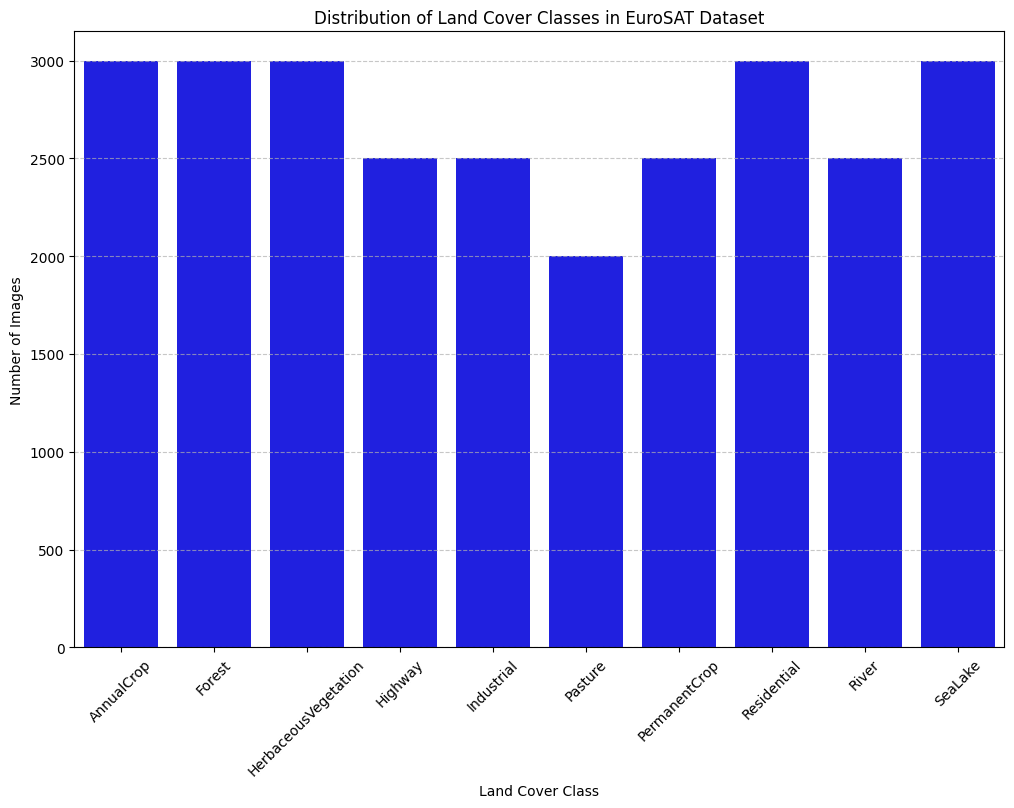

The classes are not balanced.


In [4]:
# FILL IN CODE HERE # 

unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

# Plotting the distribution of classes
plt.figure(figsize=(12, 8))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), color='blue')
plt.title('Distribution of Land Cover Classes in EuroSAT Dataset')
plt.xlabel('Land Cover Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print out whether classes are balanced
if len(set(counts)) == 1:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

Comment on class balance: 
- The graph shows that the classes are not balanced. SeaLake, for instance, has more samples than Pasture or Highway.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

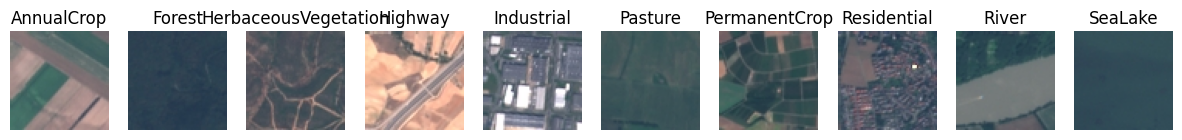

In [5]:
# FILL IN CODE HERE #

# Get unique classes and one image per class
unique_classes = np.unique(labels)
sample_images = []

# Find one example per class
for cls in unique_classes:
    # Find the index of the first occurrence of each class
    idx = np.where(labels == cls)[0][0]
    sample_images.append(images[idx])

# Plotting one image from each class
fig, axs = plt.subplots(1, len(unique_classes), figsize=(15, 5))

for i, img in enumerate(sample_images):
    axs[i].imshow(img / 255.0)  # Normalize to [0,1] for display
    axs[i].title.set_text(unique_classes[i])
    axs[i].axis('off')

plt.show()

Most confused land classes: 
- Based on the above images, we might expect the most confused classes to be Forest, SeaLake and Pasture. We might also expect that AnnualCrop and PermenantCrop are confused. 

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    # Number of samples
    num_samples = images.shape[0]
    
    # Shuffle indices
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # Calculate split indices
    train_end = int(split[0] * num_samples)
    val_end = train_end + int(split[1] * num_samples)
    
    # Split the data
    X_train = images[:train_end]
    y_train = labels[:train_end]
    X_val = images[train_end:val_end]
    y_val = labels[train_end:val_end]
    X_test = images[val_end:]
    y_test = labels[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''
    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # Normalize all images (applied to train, validation, and test)
    X = X.astype('float32') / 255.0
    
    # Image augmentation on training data
    if data_partition == "train":
        # Convert numpy arrays to tensors
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        
        # Adjust brightness
        X_augm = tf.image.adjust_brightness(X_tensor, DELTA)

        # Adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # Random flip left-right
        X_augm = tf.image.random_flip_left_right(X_augm)

        # Concatenate original X and augmented X_aug data
        X = tf.concat([X_tensor, X_augm], axis=0).numpy()  # Ensure to convert tensor back to numpy array

        # Concatenate y_train (note the label is preserved)
        y_augm = y
        y = np.concatenate([y, y_augm], axis=0)

        # Shuffle X and y, i.e., shuffle two tensors in the same order
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]  # Shuffle using numpy since X is already a numpy array
        y = y[indices]
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): [YOUR ANSWER HERE]

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [11]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 0.44070987654320987
Validation Accuracy: 0.43296296296296294


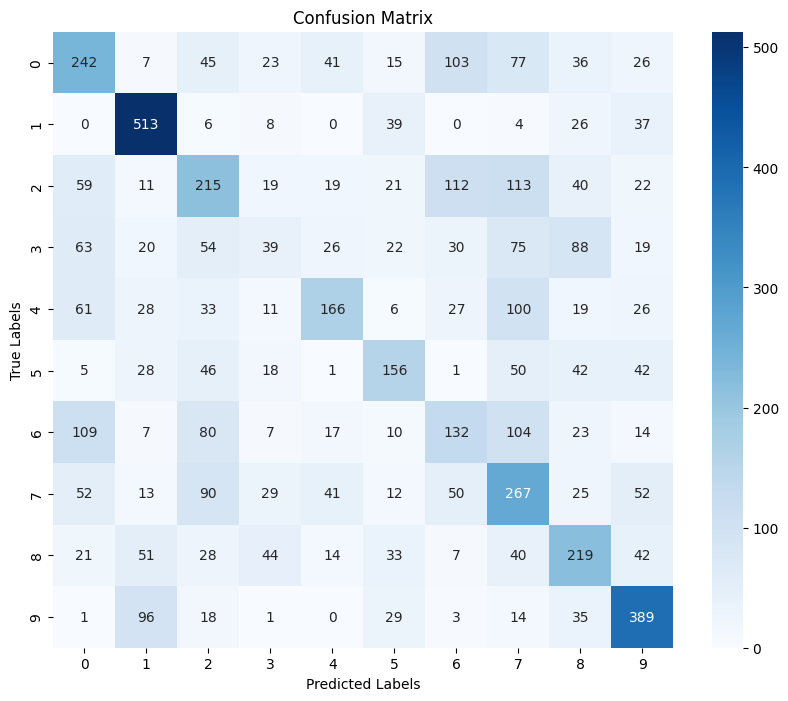

In [12]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 4: Modeling
# Define the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=2, n_jobs=1, random_state=7, max_depth=8)

# Train the model on the training data
rf_classifier.fit(X_train_re, y_train)

# Evaluate the accuracy on the training data
y_train_pred = rf_classifier.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Training Accuracy:', train_accuracy)

# Evaluate the accuracy on the validation data
y_val_pred = rf_classifier.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)

# Plot the confusion matrix for the validation data
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Comment on model accuracy on training vs. validation data: 
- The training accuracy and validation accuracy are quite close, with training at approximately 44.07% and validation at 43.30%. This close proximity in scores suggests that the model is not overfitting, as it shows similar performance on both seen (training) and unseen (validation) data.

Does the model generalize well?: 
- Yes, the model generalizes reasonably well given that the performance on the validation dataset is nearly identical to the training dataset. This indicates that the model is consistent in its predictions across datasets.

Comment on the classes that the model confuses the most:
- The confusion matrix shows significant confusion between several pairs of classes, notably class 3 and class 6, as well as class 7 and class 8. This suggests that the model struggles to differentiate between these specific classes, likely due to similar features or its insufficient learning from the available features.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Training Accuracy: 0.9967901234567901
Validation Accuracy: 0.6548148148148148


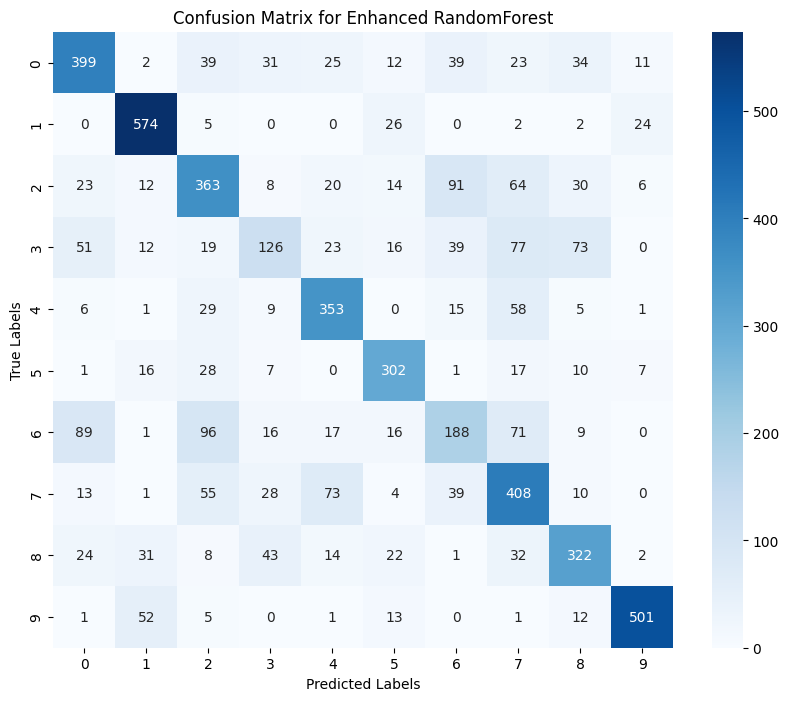

In [13]:
rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=7, min_samples_split=10, n_jobs=-1)
rf_clf2.fit(X_train_re, y_train)

# Predict on training and validation sets
y_train_pred2 = rf_clf2.predict(X_train_re)
y_val_pred2 = rf_clf2.predict(X_val_re)

# Evaluate accuracy
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
val_accuracy2 = accuracy_score(y_val, y_val_pred2)
print(f'Training Accuracy: {train_accuracy2}')
print(f'Validation Accuracy: {val_accuracy2}')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm2 = confusion_matrix(y_val, y_val_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Enhanced RandomForest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

How your implementation is different compared to the baseline classifier: 
- The enhanced RandomForestClassifier used here differs from the baseline model in several significant ways: it utilizes a higher number of estimators (100 vs. 2), deeper trees (max_depth of 20 vs. 8), and a larger minimum sample split (10 vs. default), all of which contribute to its ability to capture more complex patterns in the data.

Comment on training vs. validation performance relative to baseline model:
- The enhanced model achieved a very high training accuracy of 99.68%, a large improvement over the baseline. However, while the validation accuracy also improved significantly to 65.48%, it did not keep pace with the training performance, indicating a substantial gap that suggests overfitting.

Comment on the classes the model confuses the most relative to the baseline: 
- The confusion matrix indicates notable improvements in distinguishing between several classes; however, confusion remains high between classes 3 and 6, and 7 and 8, similar to the baseline. The model’s enhancements have reduced the number of misclassifications overall, but these specific pairs continue to pose challenges, likely due to inherent similarities in their features.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [14]:
### YOUR CODE HERE ###
# Predict on test set
y_test_pred = rf_clf2.predict(X_test_re)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Set Accuracy: {test_accuracy}')

Test Set Accuracy: 0.647962962962963


Comment on test set accuracy vs. training vs. validation set accuracy:
- The test set accuracy for the enhanced RandomForestClassifier is 64.80%, which is quite close to the validation accuracy of 65.48%. This similarity indicates that the model generalizes well to unseen data, maintaining consistent performance from the validation set to the test set. However, there is a significant gap between the training accuracy of 99.68% and both the validation and test accuracies, which suggests the model is overfitting the training data

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?
- Given the performance metrics discussed, a Decision Forest can be a viable option for land cover classification, especially when accuracy and robustness are balanced through careful hyperparameter tuning. However, the substantial gap between training (99.68%) and test (64.80%) accuracies suggests potential overfitting; thus, while Decision Forests can handle complex patterns, they may require additional regularization or complexity management strategies to improve generalization.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?
- To improve performance over the Decision Forest classifier used in Exercise 7 for land cover classification, I would propose using a Convolutional Neural Network (CNN). CNNs are highly effective for image classification tasks due to their ability to capture spatial hierarchies and intricate patterns in image data through convolutional filters and pooling layers. These models can learn to identify edges, textures, and other relevant features directly from the raw pixels, making them very suitable for complex visual tasks like distinguishing between different types of land cover.

---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?